In [1]:
from bs4 import BeautifulSoup
import numpy as np
import os
import pandas as pd
import requests
from unidecode import unidecode

from credentials import get_credentials

# JogoNaMesa

In [29]:
def get_prices():
	'''
	Scrapes www.jogonamesa.pt for board game prices. Takes NO parameters.

	Returns a list of boardgame names, and pandas DataFrame containing those games' prices.
	'''

	session = requests.session()
	login_url = 'https://jogonamesa.pt/P/user_login.cgi'
	login = session.get(login_url, headers={'User-Agent': 'Mozilla/5.0'})
	login = session.post(
						 login_url,
						 data=get_credentials()
						)

	wishlist_url = 'https://jogonamesa.pt/P/user_wishlist.cgi'
	wishlist = session.get(wishlist_url)
	wishlist_html = wishlist.text
	wishlist_soup = BeautifulSoup(wishlist_html, features='html.parser')

	pages = wishlist_soup.find_all('a', class_='paginacao')
	n_pages = int(len(pages) / 2)
	wishlist_urls = [wishlist_url + '?accao=8&num={}'.format(str(page_number)) for page_number in range(1, n_pages + 1)]

	games = {}
	bgg_ids= {}
	for url in wishlist_urls:

		page = session.get(url)
		page_html = page.content.decode('utf-8','ignore') #The decode() function here circumvents incorrectly decoded utf8 characters (mostly accented vowels)
		page_soup = BeautifulSoup(page_html, features='html.parser')
		name_blocks = page_soup.find_all('div', class_='wishlist_caracteristicas')
		price_blocks = page_soup.find_all('div', class_='wishlist_opcoes')

		for i, (name_block, price_block) in enumerate(zip(name_blocks, price_blocks)):

			name = name_block.a.string

			bgg_id = name_block.find('a', class_='bgg')['href'].split('/boardgame/')[1]
			bgg_ids[name] = int(bgg_id)

			price_tags = price_block.find_all('a', 'botao')
			try:
				prices = []
				if len(price_tags) != 0:

					for tag in price_tags:
						price = tag.contents[1].split('€')[1]
						availability = tag.find_next('span').contents[0].string
						if 'Sem prev' not in availability:
							prices.append(price)

					if len(prices) == 0:
						raise AttributeError

					games[name] = min(prices)

				else:
					raise AttributeError

			except AttributeError:
				games[name] = np.nan

	price_table = pd.DataFrame.from_dict(games, orient='index').reset_index()

	price_table.columns = ['name', 'JogoNaMesa']
	price_table['name'] = price_table['name'].astype('str')
	price_table['JogoNaMesa'] = price_table['JogoNaMesa'].astype('float')
	price_table.sort_values(by=['name'], inplace=True)
	price_table.reset_index(inplace=True)
	price_table.drop(columns=['index'], inplace=True)

	bgg_id_table = pd.DataFrame.from_dict(bgg_ids, orient='index').reset_index()
	
	bgg_id_table.columns = ['name', 'BGG_ID']
	bgg_id_table['name'] = bgg_id_table['name'].astype('str')
	bgg_id_table['BGG_ID'] = bgg_id_table['BGG_ID'].astype('int')
	bgg_id_table.sort_values(by=['name'], inplace=True)
	bgg_id_table.reset_index(inplace=True)
	bgg_id_table.drop(columns=['index'], inplace=True)

	games_list = list(games.keys())

	savepath = r'C:\Users\migue\OneDrive\Desktop\virtual_envs\board_games_web_scraping\project\data'
	filename = os.path.join(savepath, 'boardgames_bgg_ids.xlsx')
	if not os.path.isfile(filename):
		bgg_id_table.to_excel(
							filename,
							index=False,
							sheet_name='data',
							na_rep='NaN',
							)
	else:
		with pd.ExcelWriter(filename, engine='openpyxl', mode='w') as writer:
			bgg_id_table.to_excel(
								writer,
								index=False,
								sheet_name='data',
								na_rep='NaN',
								)

	return games_list, price_table

In [30]:
jogonamesa = get_prices()
# Takes only a few seconds

# GamePlay

In [7]:
def get_prices(list_of_games):
    '''
    Scrapes www.gameplay.pt for boardgame prices. Takes the following parameters:

    list_of_games (list): a list containing games of boardgames. This list is iterated over
                          to find the correspond prices on the website.

    Returns a pandas DataFrame containing the prices of all games present in list_of_games.
    '''

    session = requests.session()

    games = {}
    for i, game in enumerate(list_of_games):
        try:
            game_query = game
            if ' ' in game:
                game_query = game.replace(' ', '+')
                
            gameplay_url = 'http://www.gameplay.pt/en/search?search_query=' + game_query
            #print('url:', gameplay_url)
            gameplay_headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; W…) Gecko/20100101 Firefox/65.0'.encode('utf-8')}
            gameplay_session = session.get(gameplay_url, headers=gameplay_headers)
            gameplay_text = gameplay_session.text
            gameplay_soup = BeautifulSoup(gameplay_text, features='html.parser')

            search_results = gameplay_soup.find_all('a', class_="thumbnail product-thumbnail")

            for result in search_results:

                game_url = result.img['data-full-size-image-url']
                #print(result.img['data-full-size-image-url'])

                #print('game_name:', unidecode(game.replace('Ultimate Edition', 'Master Set').lower()).replace('-', '').replace(' ', '-').replace(':', ''))
                curated_game_name = unidecode(game.replace('Ultimate Edition', 'Master Set').lower()).replace('-', '').replace(' ', '-').replace(':', '')

                #print('game_url:', game_url.split('/')[-1].split('.')[0], '\n')
                curated_game_url = game_url.split('/')[-1].split('.')[0]
                
                # Fixes issues with "7 Wonders Duel: Agora" and "Aquatica" urls
                if 'preorder' in curated_game_url:
                    curated_game_url = curated_game_url.split('preorder-')[1]
                    #print('\n\nExtra:', curated_game_url, '\n\n')

                if curated_game_name == curated_game_url:
                    
                    #print('\n#### Found ######\n')

                    game_page = session.get(result['href'], headers=gameplay_headers)
                    game_text = game_page.text
                    game_soup = BeautifulSoup(game_text, features='html.parser')
                    price = game_soup.find('div', class_='current-price').span.text[1:]
                    break

                else:
                    price = np.nan

            games[game] = price

        except TypeError as raised_error:
            #print(raised_error)
            games[game] = np.nan

    price_table = pd.DataFrame.from_dict(games, orient='index').reset_index()
    price_table.columns = ['name', 'Gameplay']
    price_table['name'] = price_table['name'].astype('str')
    price_table['Gameplay'] = price_table['Gameplay'].astype('float')
    price_table.sort_values(by=['name'], inplace=True)
    price_table.reset_index(inplace=True)
    price_table.drop(columns=['index'], inplace=True)

    return price_table

In [9]:
gameplay = get_prices(jogonamesa[0])
# Takes ~20 minutes -> TODO: optimize

In [10]:
gameplay

,name,Gameplay
0,10 Minute Heist: The Wizard's Tower,NaN
1,1960: The Making of the President,NaN
2,3 Ring Circus,34.99
3,5-Minute Dungeon,35.99
4,5-Minute Mystery,NaN
...,...,...
539,Yedo,NaN
540,Zendo,49.99
541,Zombicide: Black Plague,125.99
542,Zooloretto,NaN


# JogarTabuleiro

In [12]:
def get_prices_jt(list_of_games):
	'''
	Scrapes www.jogartabuleiro.pt for board game prices. Takes the following parameters:

    list_of_games (list): a list containing games of boardgames. This list is iterated over
                          to find the correspond prices on the website.

    Returns a pandas DataFrame containing the prices of all games present in list_of_games.
	'''

	session = requests.session()

	games = {}
	for i, game in enumerate(list_of_games):
		#print('\n', game)
		try:
			game_query = game
			if ' ' in game:
				game_query = game.replace(' ', '-')
			if ':' in game_query:
				game_query = game_query.replace(':', '')
				
			jogartabuleiro_url = 'https://jogartabuleiro.pt/produto/' + game_query
			#print('url:', jogartabuleiro_url)
			jogartabuleiro_headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; W…) Gecko/20100101 Firefox/65.0'.encode('utf-8')}
			jogartabuleiro_session = session.get(jogartabuleiro_url, headers=jogartabuleiro_headers)
			jogartabuleiro_text = jogartabuleiro_session.text
			jogartabuleiro_soup = BeautifulSoup(jogartabuleiro_text, features='html.parser')
			#print('soup:', jogartabuleiro_soup)

			price_results = jogartabuleiro_soup.find_all('span', class_='woocommerce-Price-amount amount')
			rental_results = jogartabuleiro_soup.find_all('div', itemprop='description')
			language_results = jogartabuleiro_soup.find_all('td', class_='woocommerce-product-attributes-item__value')

			description = rental_results[0].text
			game_language = language_results[0].text.strip()

			if 'ALUGUER' in description:
				#print('Rental only')
				raise IndexError
			
			if game_language != 'Inglês':
				#print('Je ne parle pas français')
				raise IndexError

			price = price_results[1].text[1:]

			games[game] = price
		
		except IndexError as raised_error:
			#print('Game not found:', raised_error)
			games[game] = np.nan

	price_table = pd.DataFrame.from_dict(games, orient='index').reset_index()
	price_table.columns = ['name', 'JogarTabuleiro']
	price_table['name'] = price_table['name'].astype('str')
	price_table['JogarTabuleiro'] = price_table['JogarTabuleiro'].astype('float')
	price_table.sort_values(by=['name'], inplace=True)
	price_table.reset_index(inplace=True)
	price_table.drop(columns=['index'], inplace=True)

	return price_table

In [13]:
jogartabuleiro = get_prices_jt(jogonamesa[0])
# Takes around 12 minutes

In [14]:
jogartabuleiro

,name,JogarTabuleiro
0,10 Minute Heist: The Wizard's Tower,NaN
1,1960: The Making of the President,77.27
2,3 Ring Circus,NaN
3,5-Minute Dungeon,NaN
4,5-Minute Mystery,NaN
...,...,...
539,Yedo,NaN
540,Zendo,NaN
541,Zombicide: Black Plague,NaN
542,Zooloretto,NaN


# BGG

In [2]:
savepath = r'C:\Users\migue\OneDrive\Desktop\virtual_envs\board_games_web_scraping\project\data'
filename = os.path.join(savepath, 'boardgames_bgg_ids.xlsx')
bgg_ids_df = pd.read_excel(filename)
bgg_ids_df.head()

,name,BGG_ID
0,10 Minute Heist: The Wizard's Tower,194789
1,1960: The Making of the President,27708
2,3 Ring Circus,371947
3,5-Minute Dungeon,207830
4,5-Minute Mystery,294514


In [3]:
test_game = 'Last Will'
test_game_id = bgg_ids_df.query('name=="Last Will"')['BGG_ID'].values[0]
test_game_id

97842

In [4]:
session = requests.session()
bgg_url = 'http://www.boardgamegeek.com/boardgame/' + str(test_game_id)
bgg_headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; W…) Gecko/20100101 Firefox/65.0'.encode('utf-8')}
bgg_session = session.get(bgg_url, headers=bgg_headers)
bgg_text = bgg_session.text
bgg_soup = BeautifulSoup(bgg_text, features='html.parser')
bgg_soup

<!DOCTYPE html>

<html lang="en-US" ng-app="GeekApp" ng-cloak="">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1.0" id="vp" name="viewport"/>
<meta content="yes" name="apple-mobile-web-app-capable"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<title>Last Will | Board Game | BoardGameGeek</title>
<link href="https://boardgamegeek.com/boardgame/97842/last-will" rel="canonical"/>
<link href="https://cf.geekdo-static.com/icons/touch-icon180.png" rel="apple-touch-icon"/>
<link href="https://cf.geekdo-static.com/icons/favicon2.ico" rel="shortcut icon" type="image/ico"/>
<link href="https://cf.geekdo-static.com/icons/favicon2.ico" rel="icon" type="image/ico"/>
<link href="/game-opensearch.xml" rel="search" title="BGG Game Search" type="application/opensearchdescription+xml"/>
<meta content="BGG" name="apple-mobile-web-app-title"/>
<meta content="#2e2b47" name="theme-color"/>
<link href="https://api.geekdo.com" rel="preconnect"/>
<link as

In [5]:
script_obj = bgg_soup.find_all('script')[2].contents[0]
script_obj

'\n\tvar GEEK = GEEK || {};\n\tGEEK.adBlock = [];\n\tGEEK.adConfig = {"blockleaderboard":false,"blockskyscraper":false,"noadsense":false};\n\tGEEK.adSlots = {"dfp-leaderboard":{"name":"boardgame_leaderboard_728x90"},"dfp-skyscraper":{"name":"boardgame_skyscraper_160x600"},"dfp-medrect":{"name":"boardgame_rectangle_300x250"},"dfp-repeater":{"name":"boardgame_home_repeater"},"dfp-medrect-reserved-home":{"name":"boardgame_reserved_home_300x250"},"dfp-leaderboard-lg":{"name":"boardgame_home_hero"},"dfp-home-sidekick":{"name":"boardgame_home_repeater"},"dfp-inline-post":{"name":"boardgame_inline_post"}};\n\tGEEK.legacyAds = [];\n\tGEEK.bggStoreAds = [];\n\tGEEK.googleTargets = {"gameid":["97842"],"companyid":["7345","3475","29194","264","8923","7992","30552","7466","3","17786"],"familyid":["89301","20126","20123","21092","19505","14759","70948","27646","66890","5497"],"propertyid":["2001","1002","1021","2040","1079","2874","2082"],"personid":["28450","9307"],"temp_ppl":["hot"]};\n\tGEEK.use

In [6]:
curated_obj = script_obj.split('GEEK.geekitemPreload = ')[1].split(';\n\tGEEK.geekitemSettings')[0]
curated_obj

'{"item":{"itemdata":[{"datatype":"geekitem_fielddata","fieldname":"name","title":"Primary Name","primaryname":true,"required":true,"unclickable":true,"fullcredits":true,"subtype":"boardgame","keyname":"name"},{"datatype":"geekitem_fielddata","fieldname":"alternatename","title":"Alternate Names","alternate":true,"unclickable":true,"fullcredits":true,"subtype":"boardgame","keyname":"alternatename"},{"datatype":"geekitem_fielddata","fieldname":"yearpublished","title":"Year Released","fullcredits":true,"subtype":"boardgame","keyname":"yearpublished"},{"datatype":"geekitem_fielddata","fieldname":"minplayers","title":"Minimum Players","subtype":"boardgame","keyname":"minplayers"},{"datatype":"geekitem_fielddata","fieldname":"maxplayers","title":"Maximum Players","subtype":"boardgame","keyname":"maxplayers"},{"datatype":"geekitem_fielddata","fieldname":"minplaytime","title":"Minimum Playing Time","createposttext":" minutes","posttext":" minutes","subtype":"boardgame","keyname":"minplaytime"}

In [7]:
import json

json.loads(curated_obj)

{'item': {'itemdata': [{'datatype': 'geekitem_fielddata',
    'fieldname': 'name',
    'title': 'Primary Name',
    'primaryname': True,
    'required': True,
    'unclickable': True,
    'fullcredits': True,
    'subtype': 'boardgame',
    'keyname': 'name'},
   {'datatype': 'geekitem_fielddata',
    'fieldname': 'alternatename',
    'title': 'Alternate Names',
    'alternate': True,
    'unclickable': True,
    'fullcredits': True,
    'subtype': 'boardgame',
    'keyname': 'alternatename'},
   {'datatype': 'geekitem_fielddata',
    'fieldname': 'yearpublished',
    'title': 'Year Released',
    'fullcredits': True,
    'subtype': 'boardgame',
    'keyname': 'yearpublished'},
   {'datatype': 'geekitem_fielddata',
    'fieldname': 'minplayers',
    'title': 'Minimum Players',
    'subtype': 'boardgame',
    'keyname': 'minplayers'},
   {'datatype': 'geekitem_fielddata',
    'fieldname': 'maxplayers',
    'title': 'Maximum Players',
    'subtype': 'boardgame',
    'keyname': 'maxplayer

In [17]:
json.loads(curated_obj)['item']['links']['boardgamesubdomain'][0]['name'].split(' ')[0]

'Strategy'

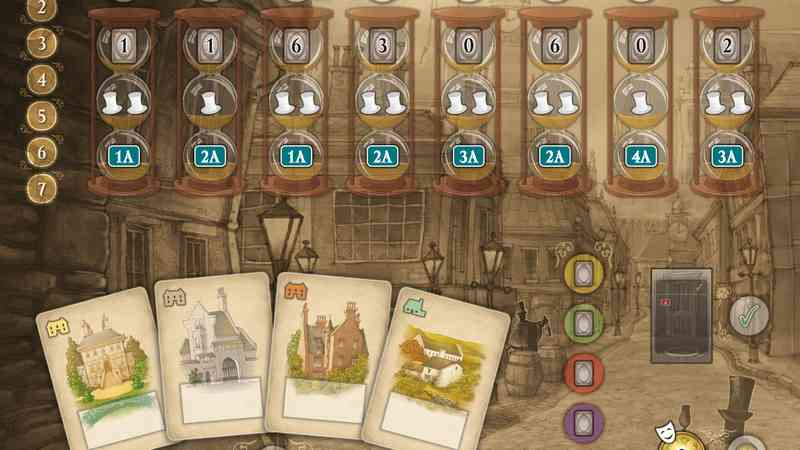

In [20]:
from PIL import Image
import requests
from io import BytesIO

language_dependence = json.loads(curated_obj)['item']['polls']['languagedependence']

average_rating = json.loads(curated_obj)['item']['stats']['average']
n_rating_votes = json.loads(curated_obj)['item']['stats']['usersrated']
complexity = json.loads(curated_obj)['item']['stats']['avgweight']

year_published = json.loads(curated_obj)['item']['yearpublished']
min_players = json.loads(curated_obj)['item']['minplayers']
max_players = json.loads(curated_obj)['item']['maxplayers']
min_playtime = json.loads(curated_obj)['item']['minplaytime']
max_playtime = json.loads(curated_obj)['item']['maxplaytime']

designer = json.loads(curated_obj)['item']['links']['boardgamedesigner'][0]['name']
artist = json.loads(curated_obj)['item']['links']['boardgameartist'][0]['name']
publisher = json.loads(curated_obj)['item']['links']['boardgamepublisher'][0]['name']

types = [json.loads(curated_obj)['item']['links']['boardgamesubdomain'][n]['name'].split(' ')[0] for n in range(len(json.loads(curated_obj)['item']['links']['boardgamesubdomain']))]
categories = [json.loads(curated_obj)['item']['links']['boardgamecategory'][n]['name'] for n in range(len(json.loads(curated_obj)['item']['links']['boardgamecategory']))]
mechanics = [json.loads(curated_obj)['item']['links']['boardgamemechanic'][n]['name'] for n in range(len(json.loads(curated_obj)['item']['links']['boardgamemechanic']))]

#img1 = json.loads(curated_obj)['item']['images']['thumb']
#img2 = json.loads(curated_obj)['item']['images']['previewthumb']
img3 = json.loads(curated_obj)['item']['images']['original']

#img4 = json.loads(curated_obj)['item']['imageurl']
bgd = json.loads(curated_obj)['item']['topimageurl']

image_url = requests.get(bgd)
img = Image.open(BytesIO(image_url.content))
img